# US college admissions dataset: Improved cutoff estimation and multiple years

In [5]:
using OneTest
using Random

using Plots, Plots.PlotMeasures
using DataFrames
ENV["COLUMNS"] = 20000

using CSV
using Statistics, StatsBase

In [2]:
# Abbreviate univ names
function nameparser(x)
    if typeof(x)<:Vector{String}
        x = replace.(x, Pair("University", "U"))
#         x = replace.(x, Pair(" College", ""))
        return x
    else
        return x
    end
end

nameparser (generic function with 1 method)

In [3]:
usadmit = CSV.File("./SchoolIncentives/demand_cutoff.csv") |> DataFrame;
usadmit[1:10, :]

10×20 DataFrame
 Row │ id      2011demand  2011cutoff  2012demand  2012cutoff  2013demand  2013cutoff  2014demand  2014cutoff  2015demand  2015cutoff  2016demand  2016cutoff  2017demand  2017cutoff  2018demand  2018cutoff  2019demand  2019cutoff   name                              
     │ Int64   Int64       Float64     Int64       Float64     Int64       Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64     Float64      String                            
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 100654         872   0.0              1033   0.0              1104   0.0            1207.0    0.0           1461.0   0.0            1568.0  0.00161798      1294.0  0.0             1529.0  0.00437965      1710.0  0.000441295  Alabama A & M University
   2 │ 100663        1605   0.419958         1605   0.419027         1773   0.495225       1748.0    0.42552       1621.0   0.476804       2021.0  0.498032        2299.0  0.523956        2299.0  0.517674        2346.0  0.558465     University of Alabama at Birming…
   3 │ 100706         677   0.557053          624   0.542295          651   0.588349        724.0    0.653101      1038.0   0.684863       1213.0  0.693114        1352.0  0.730081        1435.0  0.741696        1497.0  0.744194     University of Alabama in Huntsvi…
   4 │ 100724        1101   0.0              1106   0.0              1479   0.0            1091.0    0.0           1021.0   0.0            1172.0  0.0              967.0  0.00827352      1038.0  0.00481675      1023.0  0.000479544  Alabama State University
   5 │ 100751        5766   0.516113         6397   0.538494         6454   0.549454       6824.0    0.576267      7211.0   0.549368       7559.0  0.578728        7407.0  0.611352        6663.0  0.589508        6764.0  0.603641     The University of Alabama
   6 │ 100830         813   0.0418857         871   0.220396          579   0.0833812       613.0    0.109684       620.0   0.132359        594.0  0.149606         652.0  0.143133         757.0  0.121469         626.0  0.14052      Auburn University at Montgomery
   7 │ 100858        4202   0.605893         3852   0.636263         3726   0.64973        4592.0    0.641727      4902.0   0.656268       4529.0  0.651267        4836.0  0.651815        4783.0  0.671843        4808.0  0.681564     Auburn University
   8 │ 100937         278   0.530275          327   0.510764          356   0.558852        382.0    0.584744       441.0   0.545717        328.0  0.476539         349.0  0.552567         328.0  0.512748         332.0  0.525879     Birmingham-Southern College
   9 │ 101435         256   0.0893474         276   0.0743348         261   0.096891        227.0    0.141579       252.0   0.0768432       277.0  0.124299         294.0  0.126478         249.0  0.140422         256.0  0.119038     Huntingdon College
  10 │ 101480        1414   0.134853         1332   0.19831          1158   0.193512       1185.0    0.224479      1049.0   0.286092       1320.0  0.335365        1147.0  0.304948        1073.0  0.303677        1493.0  0.138654     Jacksonville State University

In [4]:
years = 2011:2019

# Compute preferability parameters each year (fast)
@time for yr in years 
    usadmit[!, string(yr)*"preferability"] = gammainvopt(usadmit[!, string(yr)*"demand"], usadmit[!, string(yr)*"cutoff"])
end

  0.759269 seconds (2.14 M allocations: 121.253 MiB, 9.25% gc time, 97.26% compilation time)


In [5]:
U = Float64

# Compute selectiveness parameter each year (a little slow)
# Assume cutoff from subsequent year was school's best response
# Hence we can't calculate for 2019
@time for yr in years[1:end-1]
    @show yr
    m = Market(U.(usadmit[!, string(yr) * "preferability"]), ones(U, size(usadmit)[1]))
    sig, err = sigmainvopt_disequilibrium(m, U.(usadmit[!, string(yr) * "cutoff"]), U.(usadmit[!, string(yr+1) * "cutoff"]), verbose=false)
    usadmit[!, string(yr)*"selectivity"] = sig
    usadmit[!, string(yr)*"selectivityerror"] = err
end

yr = 2011
yr = 2012
yr = 2013
yr = 2014
yr = 2015
yr = 2016
yr = 2017
yr = 2018
800.243472 seconds (374.26 M allocations: 1.503 TiB, 10.76% gc time, 0.12% compilation time)


In [14]:
# Compute averages
for stat in split("demand cutoff preferability")
    usadmit[!, "average"*stat] = mean(usadmit[!, string(yr) * stat] for yr in years)
end

usadmit[!, "averageselectivity"] = mean(usadmit[!, string(yr) * "selectivity"] for yr in years[1:end-1])

# Reorder columns
select!(usadmit, vcat("name", sort(setdiff(names(usadmit), ["name"]))))

# Sort by average preferability
sort!(usadmit, "averagepreferability", rev=true);

## Skip here to read in file from disk

In [3]:
# CSV.write("./SchoolIncentives/results2.csv", usadmit) 
usadmit = CSV.File("./SchoolIncentives/results2.csv") |> DataFrame
years = 2011:2019

2011:2019

In [4]:
usadmit[1:5, :]

5×49 DataFrame
 Row │ name                               2011cutoff  2011demand  2011preferability  2011selectivity  2011selectivityerror  2012cutoff  2012demand  2012preferability  2012selectivity  2012selectivityerror  2013cutoff  2013demand  2013preferability  2013selectivity  2013selectivityerror  2014cutoff  2014demand  2014preferability  2014selectivity  2014selectivityerror  2015cutoff  2015demand  2015preferability  2015selectivity  2015selectivityerror  2016cutoff  2016demand  2016preferability  2016selectivity  2016selectivityerror  2017cutoff  2017demand  2017preferability  2017selectivity  2017selectivityerror  2018cutoff  2018demand  2018preferability  2018selectivity  2018selectivityerror  2019cutoff  2019demand  2019preferability  averagecutoff  averagedemand  averagepreferability  averageselectivity  id     
     │ String                             Float64     Int64       Float64            Float64          Float64               Float64     Int64       Float64            Float64          Float64               Float64     Int64       Float64            Float64          Float64               Float64     Float64     Float64            Float64          Float64               Float64     Float64     Float64            Float64          Float64               Float64     Float64     Float64            Float64          Float64               Float64     Float64     Float64            Float64          Float64               Float64     Float64     Float64            Float64          Float64               Float64     Float64     Float64            Float64        Float64        Float64               Float64             Int64  
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Harvard University                   0.947855        1661          0.0256947           26.85            -2.58044e-6    0.964064        1664          0.0381526           23.875           -2.6617e-5     0.959757        1659          0.0334182           31.3              8.1947e-6     0.969005      1654.0          0.0426263           21.325           -3.11438e-5    0.954999      1660.0          0.0284563           29.45            -1.31513e-5    0.967153      1663.0          0.0386609           39.55             2.66984e-5    0.975279      1687.0          0.0505795           38.05            -6.71554e-6    0.974351      1653.0          0.0463296           27.25             3.86622e-5    0.964319      1649.0          0.032893        0.964087        1661.11             0.0374235             29.7063  166027
   2 │ University of Chicago                0.949           1411          0.0223811           20.275           -1.74226e-5    0.952872        1527          0.0261575           25.85             3.21563e-5    0.962658        1426          0.0311266           30.55             1.42862e-5    0.968263      1445.0          0.0363259           24.125            2.09089e-5    0.959938      1537.0          0.0300433           31.05            -3.42154e-5    0.968813      1591.0          0.0391126           30.15             5.06437e-5    0.967813      1736.0          0.0382324           34.45             3.70572e-5    0.971634      1805.0          0.045036            37.9              7.82408e-6    0.

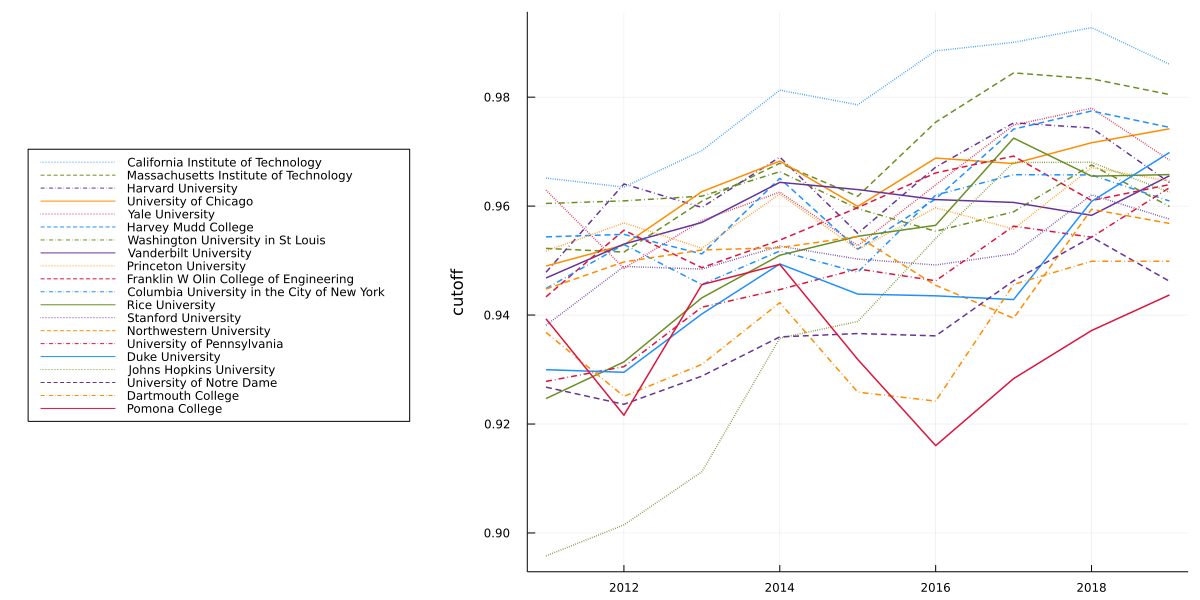

In [5]:
colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple, :darkorange]
lines = [:solid, :dot, :dash, :dashdot]

function plot_doer(stat, N=20)
    pl = plot(size=(1200, 600), legend=:outerleft, ylabel=stat)

    let years = (stat == "selectivity" ? years[1:end-1] : years)
        for (rank, id) in enumerate(partialsortperm(usadmit[!, "average"*stat], 1:N, rev=true))
            plot!(pl,
                  years,
                  [usadmit[id, string(yr) * stat] for yr in years],
                  c=colors[1 + rank % length(colors)],
                  ls=lines[1 + rank % length(lines)],
                  lw=1.5, 
                  label=usadmit[id, "name"])
        end
    end

    return pl
end

pl = plot_doer("cutoff")

# savefig(pl, "paper/singlescoreplots/top-20-cutoff-timeseries.pdf")

pl

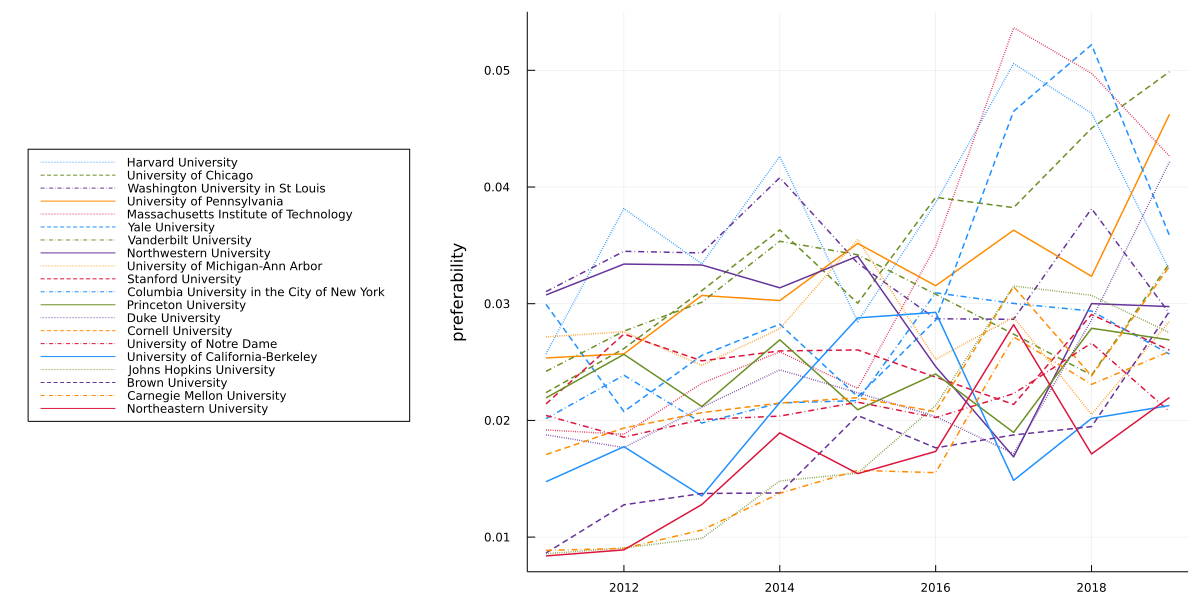

In [6]:
pl = plot_doer("preferability")

# savefig(pl, "paper/singlescoreplots/top-20-gamma-timeseries.pdf")

pl

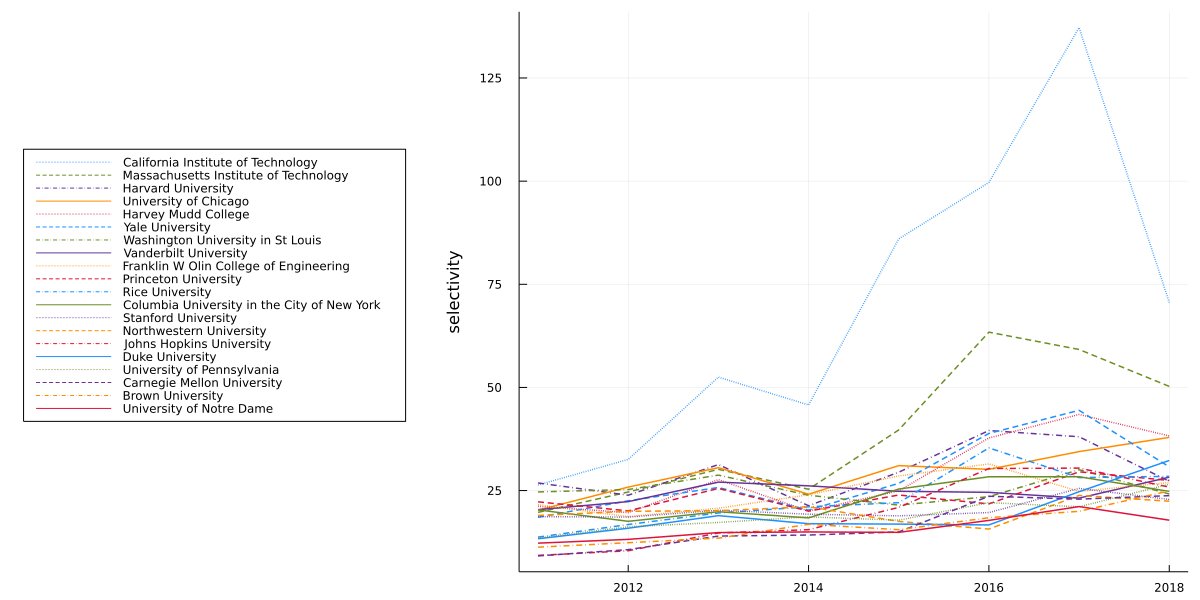

In [7]:
pl = plot_doer("selectivity")

# savefig(pl, "paper/singlescoreplots/top-20-sigma-timeseries.pdf")

pl

In [5]:
cor_cols = vcat([string(yr) * s for s in split("cutoff demand preferability") for yr in years],
                [string(yr) * "selectivity" for yr in years[1:end-1]])
                
cor_mat = cor(Matrix(usadmit[:, cor_cols]))

pl = heatmap(cor_mat[end:-1:begin, :],
             size=(920, 900),
             leftmargin=120px,
             topmargin=100px,
             color=palette(:viridis),
             colorbar_title="covariance",
             ticks=false, axis=false)

for i in 1:length(cor_cols), j in 1:length(cor_cols)
    c = (cor_mat[i, j] < 0.45 ? :white : :black)
    annotate!(pl, [(i, 1 + length(cor_cols) - j, text(round(cor_mat[i, j], digits=2), font(5, :hmiddle, :vmiddle, c)))])
end

for (x, s) in enumerate(cor_cols)
    annotate!(pl, [(x, length(cor_cols) + 0.6, text(s, font(8, rotation=45, :left, :bottom)))])
    annotate!(pl, [(0.2, 1 + length(cor_cols) - x, text(s, font(8, rotation=0, :right, :vmiddle)))])
end

# savefig(pl, "paper/singlescoreplots/cutoff-demand-gamma-sigma-corr-heatmap.pdf")

pl

In [62]:
function plot_doer_rand(stat, N=20)
    pl = plot(size=(1200, 600), legend=:outerleft, ylabel=stat)

    let years = (stat == "selectivity" ? years[1:end-1] : years)
        for (rank, id) in enumerate(partialsortperm(usadmit[!, "average"*stat], rand(1:size(usadmit)[1]-N) .+ (1:N), rev=true))
            plot!(pl,
                  years,
                  [usadmit[id, string(yr) * stat] for yr in years],
                  c=colors[1 + rank % length(colors)],
                  ls=lines[1 + rank % length(lines)],
                  lw=1.5, 
                  label=usadmit[id, "name"])
        end
    end

    return pl
end

plot_doer_rand (generic function with 2 methods)

In [ ]:
function year_pairplot(plot_years, stat)
    pl = plot(layout=(length(plot_years), length(plot_years)), size=(820, 800), legend=false, ticks=false,
              margin=-1mm)

    colors = palette(:Dark2_8)

    for (i, x) in enumerate(plot_years), (j, y) in enumerate(plot_years)

        if i==j
            histogram!(pl[i, j], log.(usadmit[!, "$(x)$(stat)"]),
                       lc=nothing, c=:steelblue)
        else
            scatter!(pl[i, j], ms=1.2, ma=0.2, msw=0.0, c=colors[abs(i-j)],
                     log.(usadmit[!, "$(x)$(stat)"]),
                     log.(usadmit[!, "$(y)$(stat)"]))
        end

        if y == plot_years[1]
            plot!(pl[i, j], ylabel=x, yguidefontsize=9, leftmargin=7mm)
        end

        if x == plot_years[end]
            plot!(pl[i, j], xlabel=y, xguidefontsize=9, bottommargin=5mm)
        end
    end
    return pl
end

pl = year_pairplot(2011:2019, "preferability")

# savefig(pl, "paper/singlescoreplots/preferability-pairplot.pdf")

pl

In [13]:
pl = year_pairplot(2011:2018, "selectivity")

# savefig(pl, "paper/singlescoreplots/selectivity-pairplot.pdf")

pl

In [38]:
using Plots, StatsBase
n = 10^6
f(x) = n * x * log(10)
x = rand(n)
b = 10.0 .^ (-5:0.2:0)
h = fit(Histogram{Float64}, x, b)
h.weights ./= diff(log10.(h.edges[1]))
plot(h; alpha=0.3, label="", xscale=:log10, xlim=extrema(b))

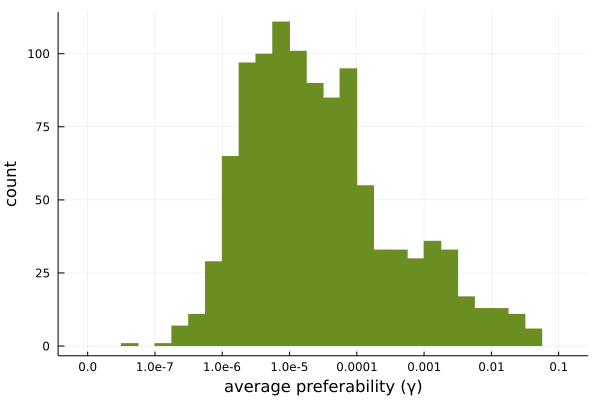

In [50]:
x = usadmit[!, "averagepreferability"]
b = 10.0 .^ vcat(-Inf, -7.75:0.25:-1)
h = fit(Histogram, x, b)

pl = bar(1:length(b), h.weights, bar_width=1.05, lc=nothing, xticks=(1:4:length(b), b[1:4:length(b)]),
         label="", xlabel="average preferability (γ)", ylabel="count", c=:olivedrab)

# savefig(pl, "paper/singlescoreplots/average-preferability-hist.pdf")

pl

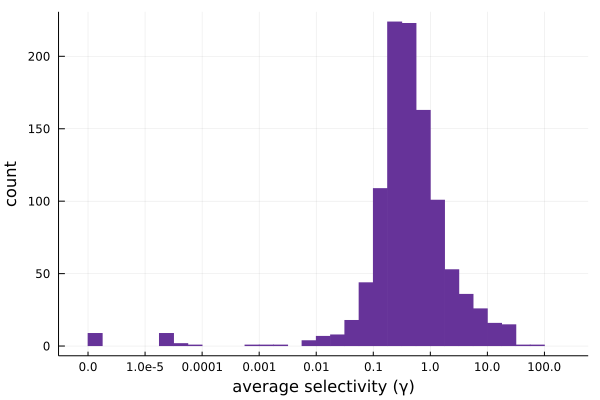

In [54]:
x = usadmit[!, "averageselectivity"]
b = 10.0 .^ vcat(-Inf, -5.75:0.25:2.25)
h = fit(Histogram, x, b)

pl = bar(1:length(b), h.weights, bar_width=1.05, lc=nothing, xticks=(1:4:length(b), b[1:4:length(b)]),
         label="", xlabel="average selectivity (γ)", ylabel="count", c=:rebeccapurple)

# savefig(pl, "paper/singlescoreplots/average-selectiveness-hist.pdf")

pl

## Updated versions of plots from previous analysis

Want to find analogues of Caltech, Whitman, and U Vermont demand curves.

1. Harvard University
2. University of Chicago
3. Washington University in St Louis
4. University of Pennsylvania
5. Massachusetts Institute of Technology
6. Yale University
7. Vanderbilt University
8. Northwestern University
9. University of Michigan-Ann Arbor
10. Stanford University
11. Columbia University in the City of New York
12. Princeton University
13. Duke University
14. Cornell University
15. University of Notre Dame
16. University of California-Berkeley
17. Johns Hopkins University
18. Brown University
19. Carnegie Mellon University
20. Northeastern University

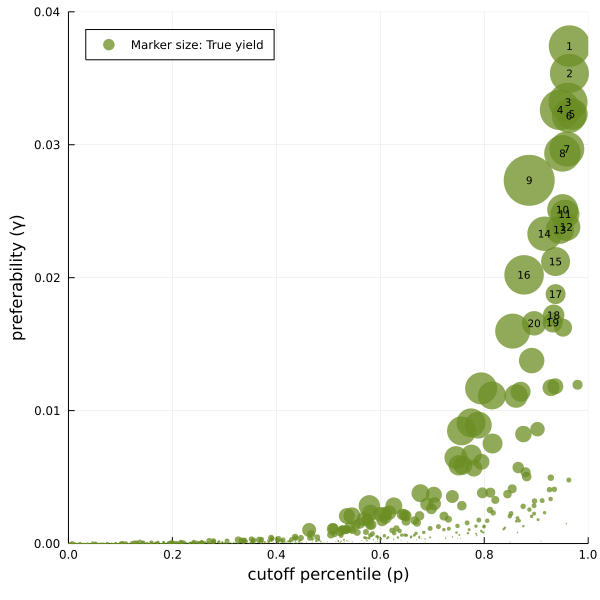

In [107]:
function plot_cutoff_gamma(stats::DataFrame)

    pl = plot(size=(600, 600), xlim=(0, 1), ylim=(0, 0.04),#1.1*maximum(stats[!, :preferability])),
              xlabel="cutoff percentile (p)", ylabel="preferability (γ)", legend=:topleft,
#               title="Admissions standards, class size and school preferability",
              titlefontsize=12)

    scatter!(pl,
             stats[!, :averagecutoff],
             stats[!, :averagepreferability],
             marker=:circle,
             ms=.0005*stats[!, :averagedemand] ./ (1 .- stats[!, :averagecutoff]),
             msw=0, msa=0,
             ma=.75,
             color=:olivedrab,
             label="Marker size: True yield")

    numsfont = text("").font
    numsfont.rotation = 0
    numsfont.halign = :hcenter
    numsfont.valign = :vcenter
    numsfont.pointsize = 7

    best = sortperm(stats[!, :averagepreferability], rev=true)

    n = 20

    for i in 1:n
        annotate!(pl,
              [(stats[best[i], :averagecutoff], 
                stats[best[i], :averagepreferability],
                text(i, numsfont))])
    end

    font = text("").font
    font.rotation = 0
    font.halign = :left
    font.valign = :top
    font.pointsize = 9

    key = join([string(i)*". "*stats[best[i], :name] for i in 1:n], '\n')
    # annotate!(pl, [(0.07, 0.043, text(key, font))])
    print(key)

    return pl
end

pl = plot_cutoff_gamma(usadmit)

# savefig(pl, "paper/singlescoreplots/US-cutoff-gamma.pdf")

pl

In [30]:
# Top 20 table. Later on we will want to add yield and true yield. 
best = sortperm(usadmit[!, :averagepreferability], rev=true)
mapcols(nameparser, usadmit[best[1:20], split("name averagecutoff averagedemand averagepreferability averageselectivity")])

20×5 DataFrame
 Row │ name                               averagecutoff  averagedemand  averagepreferability  averageselectivity 
     │ String                             Float64        Float64        Float64               Float64            
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Harvard U                               0.964087        1661.11             0.0374235            29.7063
   2 │ U of Chicago                            0.96391         1578.22             0.035366             29.2938
   3 │ Washington U in St Louis                0.961217        1698.44             0.0332036            25.2219
   4 │ U of Pennsylvania                       0.945914        2451.78             0.0326247            19.1469
   5 │ Massachusetts Institute of Techn…       0.968675        1105.22             0.032308             39.05
   6 │ Yale U                                  0.96326         1427.0              0.0321861            28.4844
   7 │ Vanderbilt U                            0.958887        1605.33             0.0296743            24.5906
   8 │ Northwestern U                          0.950487        2017.44             0.0293494            19.95
   9 │ U of Michigan-Ann Arbor                 0.886498        6474.89             0.0273232             8.40938
  10 │ Stanford U                              0.950946        1709.0              0.0251195            20.4594
  11 │ Columbia U in the City of New Yo…       0.955274        1460.22             0.024777             22.875
  12 │ Princeton U                             0.958037        1317.67             0.0238157            23.825
  13 │ Duke U                                  0.945554        1733.67             0.0236117            19.4594
  14 │ Cornell U                               0.916121        3255.67             0.0233046            12.4953
  15 │ U of Notre Dame                         0.937199        2037.78             0.021214             15.8547
  16 │ U of California-Berkeley                0.876688        5417.67             0.0202117             7.76953
  17 │ Johns Hopkins U                         0.937306        1406.44             0.0187624            19.6906
  18 │ Brown U                                 0.933626        1600.11             0.0171733            16.6
  19 │ Carnegie Mellon U                       0.931785        1524.44             0.0166263            16.6688
  20 │ Northeastern U                          0.896041        2878.22             0.0165661            10.9523

## Demand curves

We will base these on the year `base_year` for no reason.

In [67]:
U = Float64
base_year = "2015"
america = Market(log.(convert(Array{U}, usadmit[!, base_year * "preferability"])),
                       ones(U, size(usadmit)[1]))

Market{Float64}([-3.5593855162455483, -3.5051151661033826, -3.3971644531752303, -3.347682555706619, -3.783660471325069, -3.8151425662839413, -3.3757795764565044, -3.379155433766668, -3.3379462843188485, -3.6481706441532493  …  -15.450274835936485, -15.005794006745145, -15.581295093305759, -15.704740734305457, -15.72861902993735, -15.42125467185222, -16.82380156163394, -16.027262161490835, -15.94135555270481, -16.12420714603692], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.028456305280178944, 0.030043313173618875, 0.03346803572287719, 0.0351657544209663, 0.022739302332373087, 0.022034572842537913, 0.03419145306739316, 0.03407622221150893, 0.03550980994063008, 0.026038719318894857  …  1.9499833128414508e-7, 3.0413504514019146e-7, 1.7105253706953964e-7, 1.5118815226520976e-7, 1.4762079754387975e-7, 2.0074012580551125e-7, 4.93759900819289e-8, 1.0950866466158908e-7, 1.1933209066321225e-7, 9.939071421210683e-8])

In [68]:
# Should agree
hcat(sum(usadmit[!, base_year * "demand"]) * demand(america, usadmit[!, base_year * "cutoff"]), usadmit[!, base_year * "demand"])

1073×2 Matrix{Float64}:
 1660.0  1660.0
 1537.0  1537.0
 1731.0  1731.0
 2435.0  2435.0
 1106.0  1106.0
 1364.0  1364.0
 1607.0  1607.0
 2018.0  2018.0
 6092.0  6092.0
 1720.0  1720.0
 1527.0  1527.0
 1319.0  1319.0
 1746.0  1746.0
    ⋮    
   98.0    98.0
  112.0   112.0
   25.0    25.0
   13.0    13.0
   97.0    97.0
   22.0    22.0
   24.0    24.0
   16.0    16.0
   28.0    28.0
   55.0    55.0
   11.0    11.0
    3.0     3.0

In [96]:
idxs_to_plot = [50, best[156:157]...]
single_out = idxs_to_plot[1]

function calc_demand_curves(ran, idxs_to_plot)
    fixed_cuts = copy(usadmit[!, base_year * "cutoff"])
    cuts_to_plot = vcat(ran, usadmit[idxs_to_plot, base_year * "cutoff"]) |> sort
    
    total_demand = sum(usadmit[!, base_year * "demand"])
    
    res = zeros(length(cuts_to_plot), length(idxs_to_plot))
    
    for (c, i) in enumerate(idxs_to_plot)
        p = copy(fixed_cuts)
        for (d, t) in enumerate(cuts_to_plot)
            p[i] = t
            res[d, c] = demand(america, p)[i] * total_demand
        end
    end
    
    return cuts_to_plot, res
end


function plot_demand_curves(cuts, curves)
    pl = plot(xlabel="cutoff (p)", ylabel="demand (number of students)",
              size=(700, 500), yticks=([0, 5000, 10000, 15000, 20000], [0, 5000, 10000, 15000, 20000]))
    
    colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple]
    
    for (c, i) in enumerate(idxs_to_plot)
        plot!(pl,
              cuts, 
              curves[:, c],
              label=usadmit[i, :name],
              color = colors[c])
        
        vline!(pl,
               [usadmit[i, base_year * "cutoff"]],
               color = colors[c], ls=:dash, label=nothing)
    end
    
    plot!(pl, [0.75], [1], ms=nothing,
           color = :black, ls=:dash, label="Current cutoffs", legend=true)
    
    return pl
end

plot_demand_curves (generic function with 1 method)

In [86]:
single_out_curve = calc_demand_curves(range(0.92, 0.96, length=20), [single_out])

([0.92, 0.9221052631578948, 0.9242105263157895, 0.9263157894736842, 0.9284210526315789, 0.9305263157894736, 0.9326315789473684, 0.9347368421052632, 0.9368421052631579, 0.9389473684210526  …  0.9413882290619777, 0.9431578947368421, 0.9452631578947368, 0.9473684210526315, 0.9494736842105264, 0.9515789473684211, 0.9536842105263158, 0.9557894736842105, 0.9578947368421052, 0.96], [750.2967497166575; 722.0412688626278; … ; 310.73255376078714; 293.2789514825844])

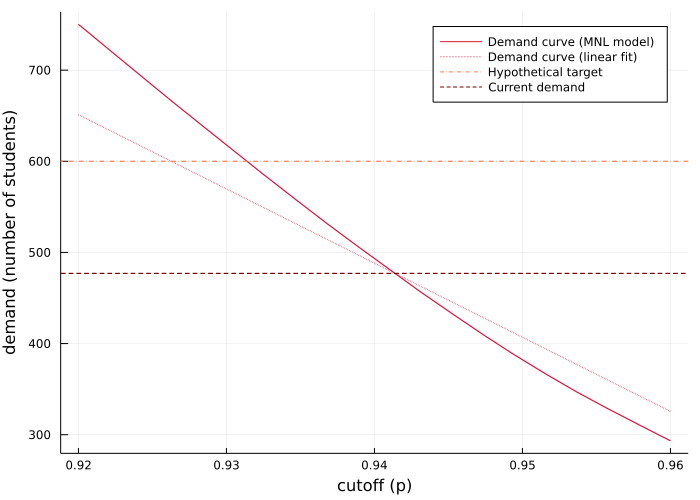

In [102]:
b, m = [1    usadmit[single_out, base_year * "cutoff"]  ;
        1                       1                       ] \ [usadmit[single_out, base_year * "demand"], 0]

function plot_single(cuts, curves)
    pl = plot(xlabel="cutoff (p)", ylabel="demand (number of students)",
              size=(700, 500))
    
    colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple]
    
    c = 1
    i = single_out
    
    plot!(pl,
          cuts, 
          curves[:, c],
          label="Demand curve (MNL model)",#invopt_results[i, :name],
          color = colors[c], lw=1.2)


    plot!(pl, [cuts[1], cuts[end]], b .+ m * [cuts[1], cuts[end]],
      ls=:dot, color = :crimson, label="Demand curve (linear fit)", lw=1.2)

    hline!(pl,
          [600],
           ls=:dashdot, c=:coral, label="Hypothetical target", lw=1.2)

    hline!(pl,
           [usadmit[i, base_year * "demand"]],
           color = :maroon, ls=:dash, label="Current demand", lw=1.2)

    return pl
end

single_plot = plot_single(single_out_curve...)

In [92]:
# Target cutoff predicted by my model; manually inspect curve to see idx
b2, m2 = [[1, 1] single_out_curve[1][6:7]] \ single_out_curve[2][6:7]
(600 - b2) / m2

0.9313875206518039

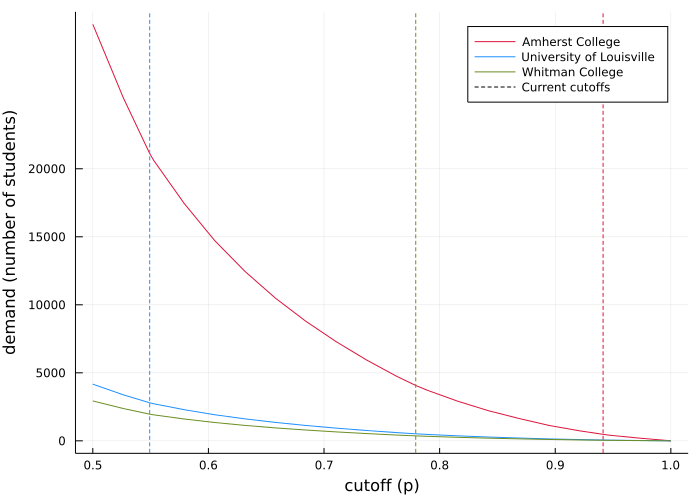

In [103]:
allthree = calc_demand_curves(range(0.5, 1, length=20), idxs_to_plot)
allthree_plot = plot_demand_curves(allthree...)

In [106]:
# savefig(single_plot, "paper/singlescoreplots/single-demand-curve.pdf")

# savefig(allthree_plot, "paper/singlescoreplots/three-demand-curves.pdf")